## Import libraries

In [59]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import r2_score
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## Load the training and testing set

In [60]:
df_train = pd.read_csv('../data/training_set.csv', index_col = 0)
df_test = pd.read_csv('../data/testing_set.csv', index_col = 0)

In [61]:
X_train = df_train.drop("price", axis = 1)
y_train = df_train["price"]
X_test = df_test.drop("price", axis = 1)
y_test = df_test["price"]

## XGBoost

#### First, we try the default hyperparameters of XGBoost

In [97]:
# params = trial.best_params
default_model = xgb.XGBRegressor()
# model = xgb.XGBRegressor(**params)
default_model.fit(X_train, y_train)
y_preds = default_model.predict(X_test)
r2_train = r2_score(y_train, default_model.predict(X_train))
r2_test = r2_score(y_test, y_preds)
print("R2 score for XGBoost model (test):", r2_test)
print("R2 score for XGBoost model (train):", r2_train)

R2 score for XGBoost model (test): 0.820042995191251
R2 score for XGBoost model (train): 0.9957583381538956


In [64]:
default_model.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

#### Now we utilize some hyperparameter tuning method to improve this

##### 1. Grid Search Cross Validation

In [43]:
params = {
        'gamma': [0, 0.5, 1, 5],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 6, 10],
        'n_estimators':[50,100,200],
        'reg_alpha': [0, 0.5, 1, 5],
        'reg_lambda': [0, 0.5, 1, 5]
        }

In [44]:
model = xgb.XGBRegressor() 

In [45]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=params,
    scoring = 'r2',
    n_jobs = -1,
    cv = 5,
    verbose=True
)

In [46]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 0.5, 1, 5], 'max_depth': [3, 4, 6, 10],
                         'n_estimators': [50, 100, 200],
                         'reg_alpha': [0, 0.5, 1, 5],
                         'reg_lambda': [0, 0.5, 1, 5]},
             scoring='r2', verbose=True)

In [47]:
print('Best Score: %s' % grid_search.best_score_)
print('Best Hyperparameters: %s' % grid_search.best_params_)

Best Score: 0.7816049254069652
Best Hyperparameters: {'colsample_bytree': 0.6, 'gamma': 0, 'max_depth': 4, 'n_estimators': 50, 'reg_alpha': 1, 'reg_lambda': 1}


In [48]:
tuned_model = xgb.XGBRegressor(**grid_search.best_params_) 
tuned_model.fit(X_train, y_train)
y_preds = tuned_model.predict(X_test)
r2_train = r2_score(y_train, tuned_model.predict(X_train))
r2_test = r2_score(y_test, y_preds)
print("R2 score for XGBoost model (test):", r2_test)
print("R2 score for XGBoost model (train):", r2_train)

R2 score for XGBoost model (test): 0.8069958462026687
R2 score for XGBoost model (train): 0.9630734393870292


#### 2. Bayesian Optimization

As hyperparameters' space of XGboost are very large, we use Bayesian optimization to find the best one

In [49]:
def objective(trial):
    """Define the objective function"""
    # train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.15,random_state=42)
    params = {
        'max_depth': trial.suggest_categorical('max_depth', [6,8,12,18]),
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.1, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6, 0.7, 0.8, 0.9, 1.0]),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'random_state': 1
    }

    # Fit the model
    model = xgb.XGBRegressor(**params)  
    r2 = cross_val_score(model, X_train, y_train, cv=5, scoring = 'r2').mean()
    return r2

In [50]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=80)

[I 2023-02-09 20:23:21,284] A new study created in memory with name: no-name-bc1dfa9e-e3e9-4c77-9b20-ba6b8b5e9e74
[I 2023-02-09 20:23:24,828] Trial 0 finished with value: 0.6720733814833084 and parameters: {'max_depth': 12, 'lambda': 1.8326651059349077, 'alpha': 0.04055682836162767, 'learning_rate': 0.23011572697170327, 'n_estimators': 322, 'min_child_weight': 10, 'gamma': 1.2301460030139548e-08, 'subsample': 0.3458091659283626, 'colsample_bytree': 0.9, 'reg_alpha': 0.00017918705903647447, 'reg_lambda': 0.40664294169340676}. Best is trial 0 with value: 0.6720733814833084.
[I 2023-02-09 20:23:26,339] Trial 1 finished with value: 0.657095512323312 and parameters: {'max_depth': 12, 'lambda': 0.018990827595677117, 'alpha': 0.0014552587410801596, 'learning_rate': 0.135633419882919, 'n_estimators': 263, 'min_child_weight': 3, 'gamma': 0.00013194828984987604, 'subsample': 0.027491956450837764, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009540708698200513, 'reg_lambda': 0.06749594835231834}. Bes

In [51]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
trial = study.best_trial
print('Best Value: {}'.format(trial.value))
print('Best Params: ')

for key, value in trial.params.items():
    print('{}: {}'.format(key, value))

Number of finished trials: 80
Best trial: {'max_depth': 6, 'lambda': 1.6270378198657665, 'alpha': 0.17478550135384122, 'learning_rate': 0.10094231455222795, 'n_estimators': 406, 'min_child_weight': 4, 'gamma': 3.517885698459128e-07, 'subsample': 0.41524912933830593, 'colsample_bytree': 0.7, 'reg_alpha': 0.03972944253323202, 'reg_lambda': 2.7571048655044116e-05}
Best Value: 0.7651814691060089
Best Params: 
max_depth: 6
lambda: 1.6270378198657665
alpha: 0.17478550135384122
learning_rate: 0.10094231455222795
n_estimators: 406
min_child_weight: 4
gamma: 3.517885698459128e-07
subsample: 0.41524912933830593
colsample_bytree: 0.7
reg_alpha: 0.03972944253323202
reg_lambda: 2.7571048655044116e-05


In [54]:
tuned_model = xgb.XGBRegressor(**trial.params) 
tuned_model.fit(X_train, y_train)
y_preds = tuned_model.predict(X_test)
r2_train = r2_score(y_train, tuned_model.predict(X_train))
r2_test = r2_score(y_test, y_preds)
print("R2 score for XGBoost model (test):", r2_test)
print("R2 score for XGBoost model (train):", r2_train)

R2 score for XGBoost model (test): 0.7786232526434065
R2 score for XGBoost model (train): 0.9887110548607402


### Explain the model's predictions on the entire dataset

As the default XGBoost model has the best performance among all the regression models, we will use this model to intepret our results

In [78]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [90]:
df_train = pd.read_csv('../model/Data used for interpreting/training_set.csv', index_col = 0)
df_test = pd.read_csv('../model/Data used for interpreting/testing_set.csv', index_col = 0)
X_train = df_train.drop("price", axis = 1)
y_train = df_train["price"]
X_test = df_test.drop("price", axis = 1)
y_test = df_test["price"]

In [91]:
X = pd.concat([X_train, X_test], axis = 0)
y = pd.concat([y_train, y_test], axis = 0)

Here we use the Tree SHAP implementation integrated into XGBoost to explain the entire dataset.

In [98]:
explainer = shap.TreeExplainer(default_model)
shap_values = explainer.shap_values(X)

#### Visualize a single prediction

In [99]:
X.iloc[6,:]

battery                 80.00
weight                   2.00
monitor_size            15.60
ram_capacity             8.00
SSD_capacity           512.00
cpu_core_num             9.20
cpu_thread_num          13.60
avg_bench               79.16
gamming                 79.00
desktop                 84.60
workstation             75.20
gpu_score               58.50
website_thinkpro         0.00
cpu_brand_Apple          0.00
laptop_brand_Asus        0.00
laptop_brand_Dell        0.00
laptop_brand_Lenovo      0.00
laptop_brand_Other       1.00
laptop_brand_Razer       0.00
Name: 6, dtype: float64

In [100]:
shap.force_plot(explainer.expected_value, shap_values[6,:], X.iloc[6,:])

#### Visualize the whole dataset

In [101]:
shap.force_plot(explainer.expected_value, shap_values, X)

### Bar chart of mean importance¶
This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

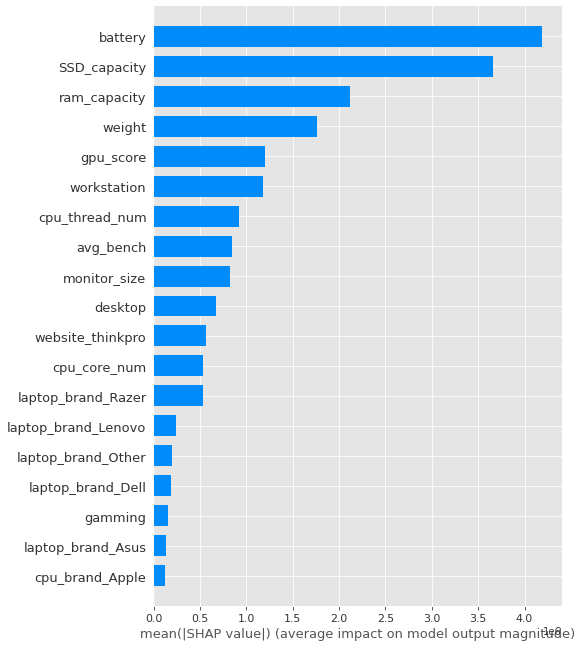

In [102]:
shap.summary_plot(shap_values, X, plot_type="bar")

Suprisingly, the battery feature is actually the most important, followed by the SSD_capacity feature

#### SHAP Summary Plot
Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the battery feature has more total model impact than the gpu_score, avg_bench features. While SSD_capacity is not the most important feature globally, it is by far the most important feature for a subset of customers. The coloring by feature value shows us patterns such as how large monitor decrease the price, and if it is a Razer laptopor have higher ram capacity, there is a high chance that's an expensive one. We can also see that if a laptop brand is "other" or not belonds to a popular brand, the price will decrease quite significantly

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

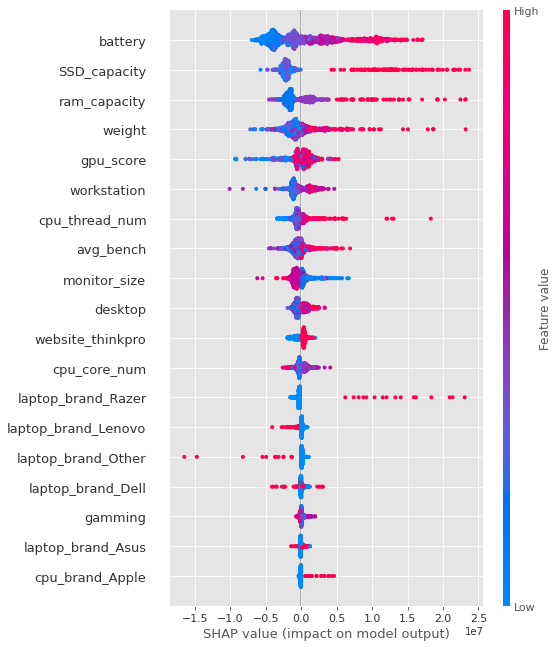

In [104]:
shap.summary_plot(shap_values, X)

### SHAP Dependence Plots
SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

In [107]:
X.columns

Index(['battery', 'weight', 'monitor_size', 'ram_capacity', 'SSD_capacity',
       'cpu_core_num', 'cpu_thread_num', 'avg_bench', 'gamming', 'desktop',
       'workstation', 'gpu_score', 'website_thinkpro', 'cpu_brand_Apple',
       'laptop_brand_Asus', 'laptop_brand_Dell', 'laptop_brand_Lenovo',
       'laptop_brand_Other', 'laptop_brand_Razer'],
      dtype='object')

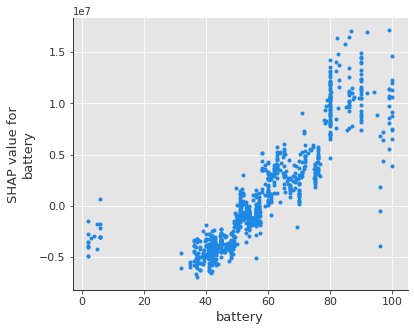

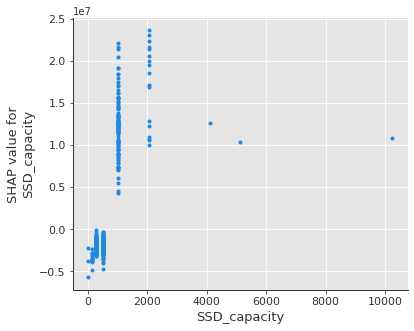

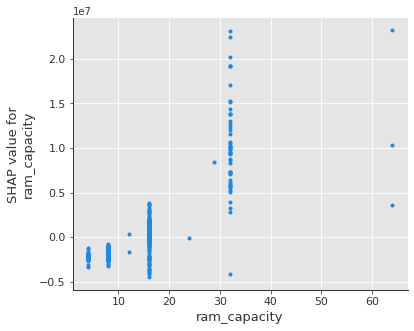

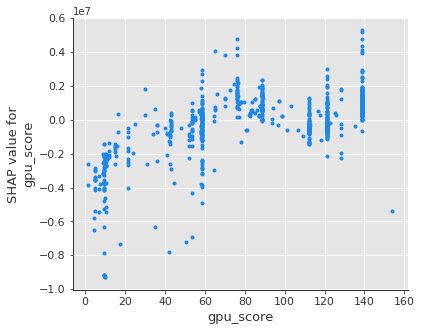

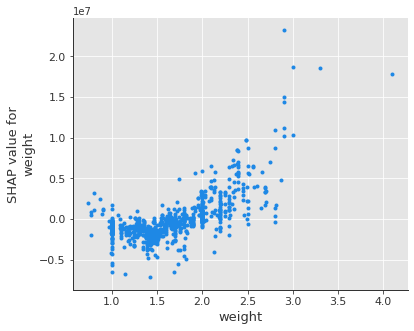

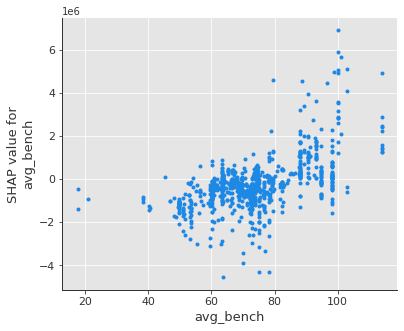

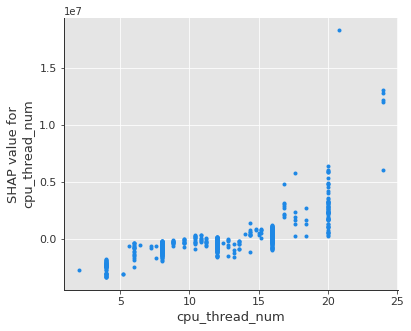

In [111]:
for name in ['battery', 'SSD_capacity', 'ram_capacity', 'gpu_score', 'weight', 'avg_bench', 'cpu_thread_num']:
    shap.dependence_plot(name, shap_values, X, interaction_index=None)


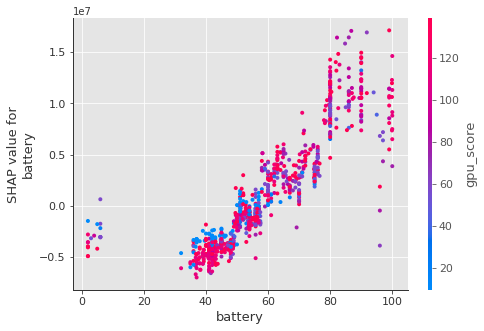

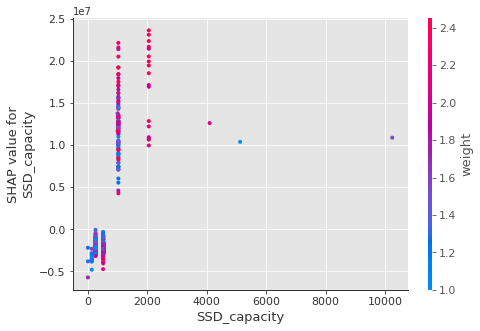

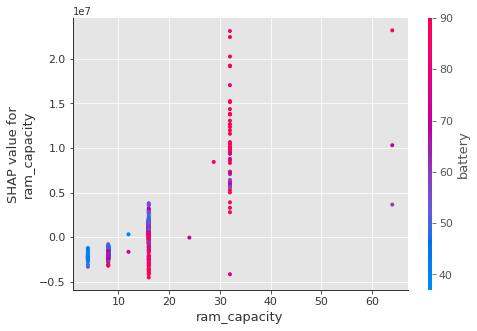

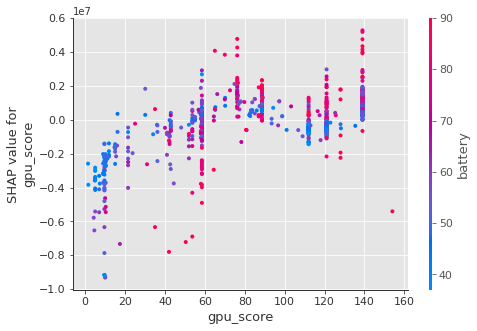

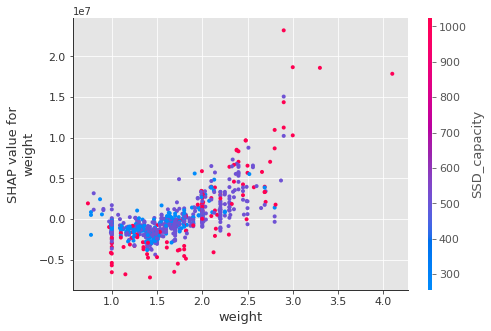

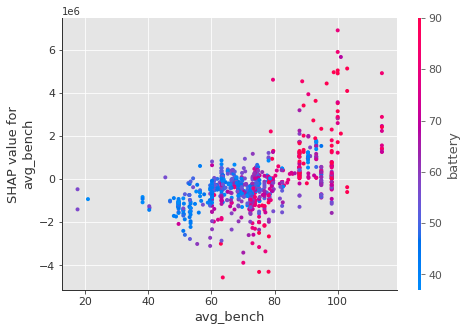

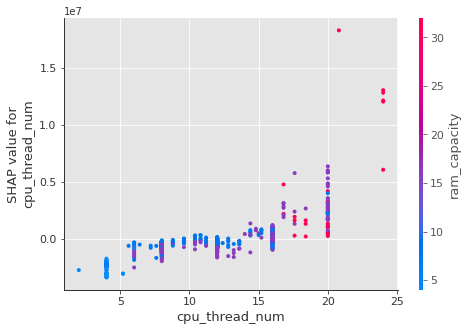

In [112]:
for name in ['battery', 'SSD_capacity', 'ram_capacity', 'gpu_score', 'weight', 'avg_bench', 'cpu_thread_num']:
    shap.dependence_plot(name, shap_values, X)